# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [293]:
import json
from collections import defaultdict
from dataclasses import dataclass

import numba
import pandas as pd
import numpy as np
from numba.core.types import uint64
from pandas.core.interchange.dataframe_protocol import Column, DataFrame
from pandas.core.util.hashing import hash_pandas_object
from setuptools.config.pyprojecttoml import load_file
from sklearn.compose import ColumnTransformer
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import OneHotEncoder
#import kshingle as ks
import os
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np
from datasketch import MinHash, MinHashLSH
from collections import defaultdict
from typing import Dict, List, Set, Tuple, NamedTuple
import re
import json
import pickle
from datasketch import MinHash, MinHashLSH
from typing import Callable, Generator, Iterable, List, Optional, Tuple
import numpy
import numpy as np
from tqdm import tqdm
from datasketch.hashfunc import sha1_hash32
from tqdm import tqdm


In [294]:
# This can be used to load the dataset
data = pd.read_csv("adult.csv", header=0, na_values='?')
data = data.dropna()

data = data.convert_dtypes()

numericals = data.select_dtypes(include=[np.number]).columns
categoricals = data.select_dtypes(exclude=[np.number]).columns

data[categoricals] = data[categoricals].astype('category')

encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categoricals)], remainder='passthrough')

#dt = encoder.fit_transform(data)

#for c in data.columns:
#    if data[c].dtype == 'object':
#        data[c] = pd.Categorical(data[c])

#print(dt)
data.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [295]:
print(data.dtypes)

age                  Int64
workclass         category
fnlwgt               Int64
education         category
education-num        Int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         Int64
capital-loss         Int64
hours-per-week       Int64
native-country    category
salary            category
dtype: object


### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [296]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define your preprocessing steps here
steps = []

# Combine steps into a ColumnTransformer
ct = ColumnTransformer(steps)

# show the correlation between different features including target variable
def visualize(data, ct):
    pass

# Apply your model to feature array X and labels y
def apply_model(model, X, y):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('t', ct), ('m', model)])
    
    # Evaluate the model and store results
    return evaluate_model(X, y, pipeline)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline):
    pass

### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [297]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y: np.ndarray, fraction: float) -> np.ndarray:
    copy = data.copy()
    # Flip fraction*len(data) of the labels in copy
    return copy

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [298]:
# Code

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



Discovery algorithm:
1. Scan each database with read_csv.
2. Flatten each database, convert it to one string
3. Shingle with k=6
4. The MinHash and CMinHash values are calculated for each set of shingles
5. LSH returns pairs of columns with similarities above a threshold.


In [299]:
@numba.jit(nopython=True)
def kshingle_manual(s, k=6):
   sh = set()
   for i in range(len(s) - k + 1):
       sh.add(s[i:i + k])
   return list(sh)

We run the experiment twice for dirty and clean datasets.

In [300]:
csv_path = "./lake33c"

In [301]:
from collections import namedtuple
from collections import defaultdict
import os
import re
import pandas as pd

ColStruct = namedtuple("ColStruct", ["index", "col_name", "value"])

df_dict = {}
df_col_dict = defaultdict(list)

error_count_file = 0
for root, dirs, files in os.walk(csv_path):
    for csv_file in files:
        if os.path.splitext(csv_file)[1] == ".csv":
            file_path = os.path.join(root, csv_file)
            try:
                # Naive read_csv() as mentionmed ion the report
                df = pd.read_csv(file_path, sep=None, engine='python', on_bad_lines='skip', header=0)
                df = df.dropna().astype(object)
                # print(df)
            except Exception as e:
                continue
            # Serialize whole file (flattened)
            df_str = df.to_numpy().flatten()
            df_str = " ".join(str(x) for x in df_str).replace("\n", " ")
            df_str = re.sub(r"\s+", " ", df_str).strip()
            df_dict[csv_file] = df_str

            # Serialize each column for this file
            for col_idx, col in enumerate(df.columns):
                col_arr = df[col].to_numpy().flatten()
                if not dirty:
                    col_str = " ".join(str(x) for x in col_arr).replace("\n", " ")
                    col_str = re.sub(r"\s+", " ", col_str).strip()
                else:
                    col_str = str(col_arr)
                df_col_dict[csv_file].append(ColStruct(index=col_idx, col_name=str(col), value=col_str))

print(error_count_file)

0


22s to read files

In [302]:
from datasketch import MinHash, MinHashLSH
from typing import Callable, Generator, Iterable, List, Optional, Tuple
import numpy
import numpy as np
from tqdm import tqdm
from datasketch.hashfunc import sha1_hash32
from tqdm import tqdm

import numba as nb
import numpy as np


The datasketch.MinHash module is a good starting point to build the CMinHash algorithm.

For MinHash, at the beginning I did not really understand what the algorithm does.
Working on extending a module instead of starting from scratch helped me understand the algorithm better. I also learned about batch processing from datasketch.MinHash.

In [303]:
minhash_files = {}
cminhash_files = {}
cminhash_files_pi = {}
cminhash_cols = defaultdict(list)
cminhash_cols_pi = defaultdict(list)
minhash_cols = defaultdict(list)
lookup = {}
mh_file_ind = 0
hashvalue_byte_size = 4
# The size of a hash value in number of bytes


class CMinHashTest(MinHash):

    _large_prime = np.uint64((1 << 31) - 1) # A large prime
    _hash_range = 1 << 31

    def __init__(self, num_perm: int = 128, seed: int = 1234, hashfunc: Callable = sha1_hash32,
                 hashobj: Optional[object] = None, hashvalues: Optional[Iterable] = None,
                 permutations: Optional[Tuple[Iterable, Iterable]] = None, c_minhash_rotations: Optional[int] = None) -> None:
        super().__init__(num_perm, seed, hashfunc, hashobj, hashvalues, permutations)
        if c_minhash_rotations is not None: # Hard code
            self.c_minhash_rotations = c_minhash_rotations
        self.pi_permutations = self._init_pi_permutations()
        self.sigma_permutations = self._init_sigma_permutations()
        self.shift_right_precomputed = np.array([k for k in range(1, self.c_minhash_rotations + 1)], dtype=np.uint64).T


    def _init_sigma_permutations(self):
        gen = np.random.RandomState(self.seed + 1) # So we get different values for sigma permutation
        return np.array([
            gen.randint(1, self._large_prime, dtype=np.uint64),
            gen.randint(0, self._large_prime, dtype=np.uint64),
        ], dtype=np.uint64).T

    def _init_pi_permutations(self):
        # Create parameters for a random bijective permutation function
        # that maps a 32-bit hash value to another 32-bit hash value.
        # http://en.wikipedia.org/wiki/Universal_hashing
        gen = np.random.RandomState(self.seed)
        return np.array(
            [
                (
                    gen.randint(1, self._large_prime, dtype=np.uint64),
                    gen.randint(0, self._large_prime, dtype=np.uint64),
                )
            ],
            dtype=np.uint64,
        ).T


    def sf(self, hv):
        a, b = self.sigma_permutations
        return (hv * a + b) % self._large_prime

    def pf(self, hv) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * a + b) % self._large_prime

    # Another way of shifting the permutations.
    # The k offset is introduced at the end of the operation, instead of the beginning.
    # Here, "pia" holds (a * k + b % p) for all k.
    # https://github.com/beowolx/rensa/blob/95d80780f52f3105df4433132b279acd8c2762a0/src/cminhash.rs
    def pf2(self, hv, pia) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * a + pia) % self._large_prime

    def pf3(self, hv, off) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * (a - off) + b) % self._large_prime



    def update_batch_cminhash_pi_pi(self, b: Iterable) -> None:
        """Update this MinHash with new values.
        The values will be hashed using the hash function specified by
        the `hashfunc` argument in the constructor.

        """
        if self.c_minhash_rotations is None:
            raise ValueError("You need to specify c_minhash_rotations")

        hv = np.array([self.hashfunc(_b) for _b in b], dtype=np.uint64, ndmin=2).T
        phv = self.pf(hv)
        phv = self.pf3(phv, self.shift_right_precomputed)

        self.hashvalues = np.vstack([phv, self.hashvalues]).min(axis=0)


    def update_batch_cminhash_sigma_pi(self, b: Iterable) -> None:
        """Update this MinHash with new values.
        The values will be hashed using the hash function specified by
        the `hashfunc` argument in the constructor.

        """
        if self.c_minhash_rotations is None:
            raise ValueError("You need to specify c_minhash_rotations")

        hv = np.array([self.hashfunc(_b) for _b in b], dtype=np.uint64, ndmin=2).T
        phv = self.sf(hv)
        phv = self.pf3(phv, self.shift_right_precomputed)

        self.hashvalues = np.vstack([phv, self.hashvalues]).min(axis=0)


In [304]:

text_shinglesets = {}
col_shinglesets = defaultdict(set)

for fname, text in tqdm(df_dict.items()):
    cmh = CMinHashTest(num_perm=256, c_minhash_rotations=256)
    cmhp = CMinHashTest(num_perm=256, c_minhash_rotations=256)
    mh = MinHash(num_perm=256)

    ks = kshingle_manual(text)
    text_shinglesets[fname] = tuple(ks)
    max_buf=128
    for i in range(0, len(ks), max_buf):
        bufsize = min(len(ks)-i, max_buf)
        cmh.update_batch_cminhash_sigma_pi([e.encode("utf8") for e in ks[i:i+bufsize]])
        cmhp.update_batch_cminhash_pi_pi([e.encode("utf8") for e in ks[i:i+bufsize]])
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        cmh_col = CMinHashTest(num_perm=256, c_minhash_rotations=256)
        cmhp_col = CMinHashTest(num_perm=256, c_minhash_rotations=256)

        ks = kshingle_manual(col_value)
        cmh_col.update_batch_cminhash_sigma_pi([e.encode("utf8") for e in ks])
        cmhp_col.update_batch_cminhash_pi_pi([e.encode("utf8") for e in ks])
        cminhash_cols[fname].append(ColStruct((fname, col_idx), col_name ,cmh_col))
        cminhash_cols_pi[fname].append(ColStruct((fname, col_idx), col_name ,cmhp_col))
    cminhash_files[fname] = cmh
    cminhash_files_pi[fname] = cmhp


    for i in range(0, len(ks), max_buf):
        bufsize = min(len(ks)-i, max_buf)
        mh.update_batch([e.encode("utf8") for e in ks[i:i+bufsize]])
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        mh_col = MinHash(num_perm=256)
        ks = kshingle_manual(col_value)
        mh_col.update_batch([e.encode("utf8") for e in ks])
        minhash_cols[fname].append(ColStruct((fname, col_idx), col_name ,mh_col))

        col_shinglesets[fname].add(ColStruct((fname, col_idx), col_name, tuple(ks)))


    minhash_files[fname] = mh



100%|██████████| 15/15 [01:03<00:00,  4.26s/it]


In [305]:
import matplotlib.pyplot as plt

def jaccard_manual(set1, set2):
    set1 = set(set1)
    set2 = set(set2)

    intersection = set1.intersection(set2)
    union = set1.union(set2)

    if len(intersection) == 0:
        return 0.0
    return len(intersection) / len(union)


hash_scores = {}
chash_scores = {}
chash_scores_pi = {}
plain_scores = {}
for fname, content in minhash_files.items():
    hash_scores[fname] = {f: minhash_files[f].jaccard(content) for f in minhash_files.keys()}
for fname, content in cminhash_files.items():
    chash_scores[fname] = {f: cminhash_files[f].jaccard(content) for f in cminhash_files.keys()}

for fname, content in cminhash_files_pi.items():
    chash_scores_pi[fname] = {f: cminhash_files_pi[f].jaccard(content) for f in cminhash_files_pi.keys()}
for fname, content in text_shinglesets.items():
    plain_scores[fname] = {f: jaccard_manual(text_shinglesets[f], content) for f in text_shinglesets.keys()}

df = pd.DataFrame(hash_scores)
cdf = pd.DataFrame(chash_scores)
pdf = pd.DataFrame(plain_scores)
cpdf = pd.DataFrame(chash_scores_pi)

df.to_csv("outputs/hash_scores_clean.csv", index=False)
cdf.to_csv("outputs/chash_scores_clean.csv", index=False)
pdf.to_csv("outputs/plain_scores_clean.csv", index=False)
cpdf.to_csv("outputs/chash_scores_pi_clean.csv", index=False)



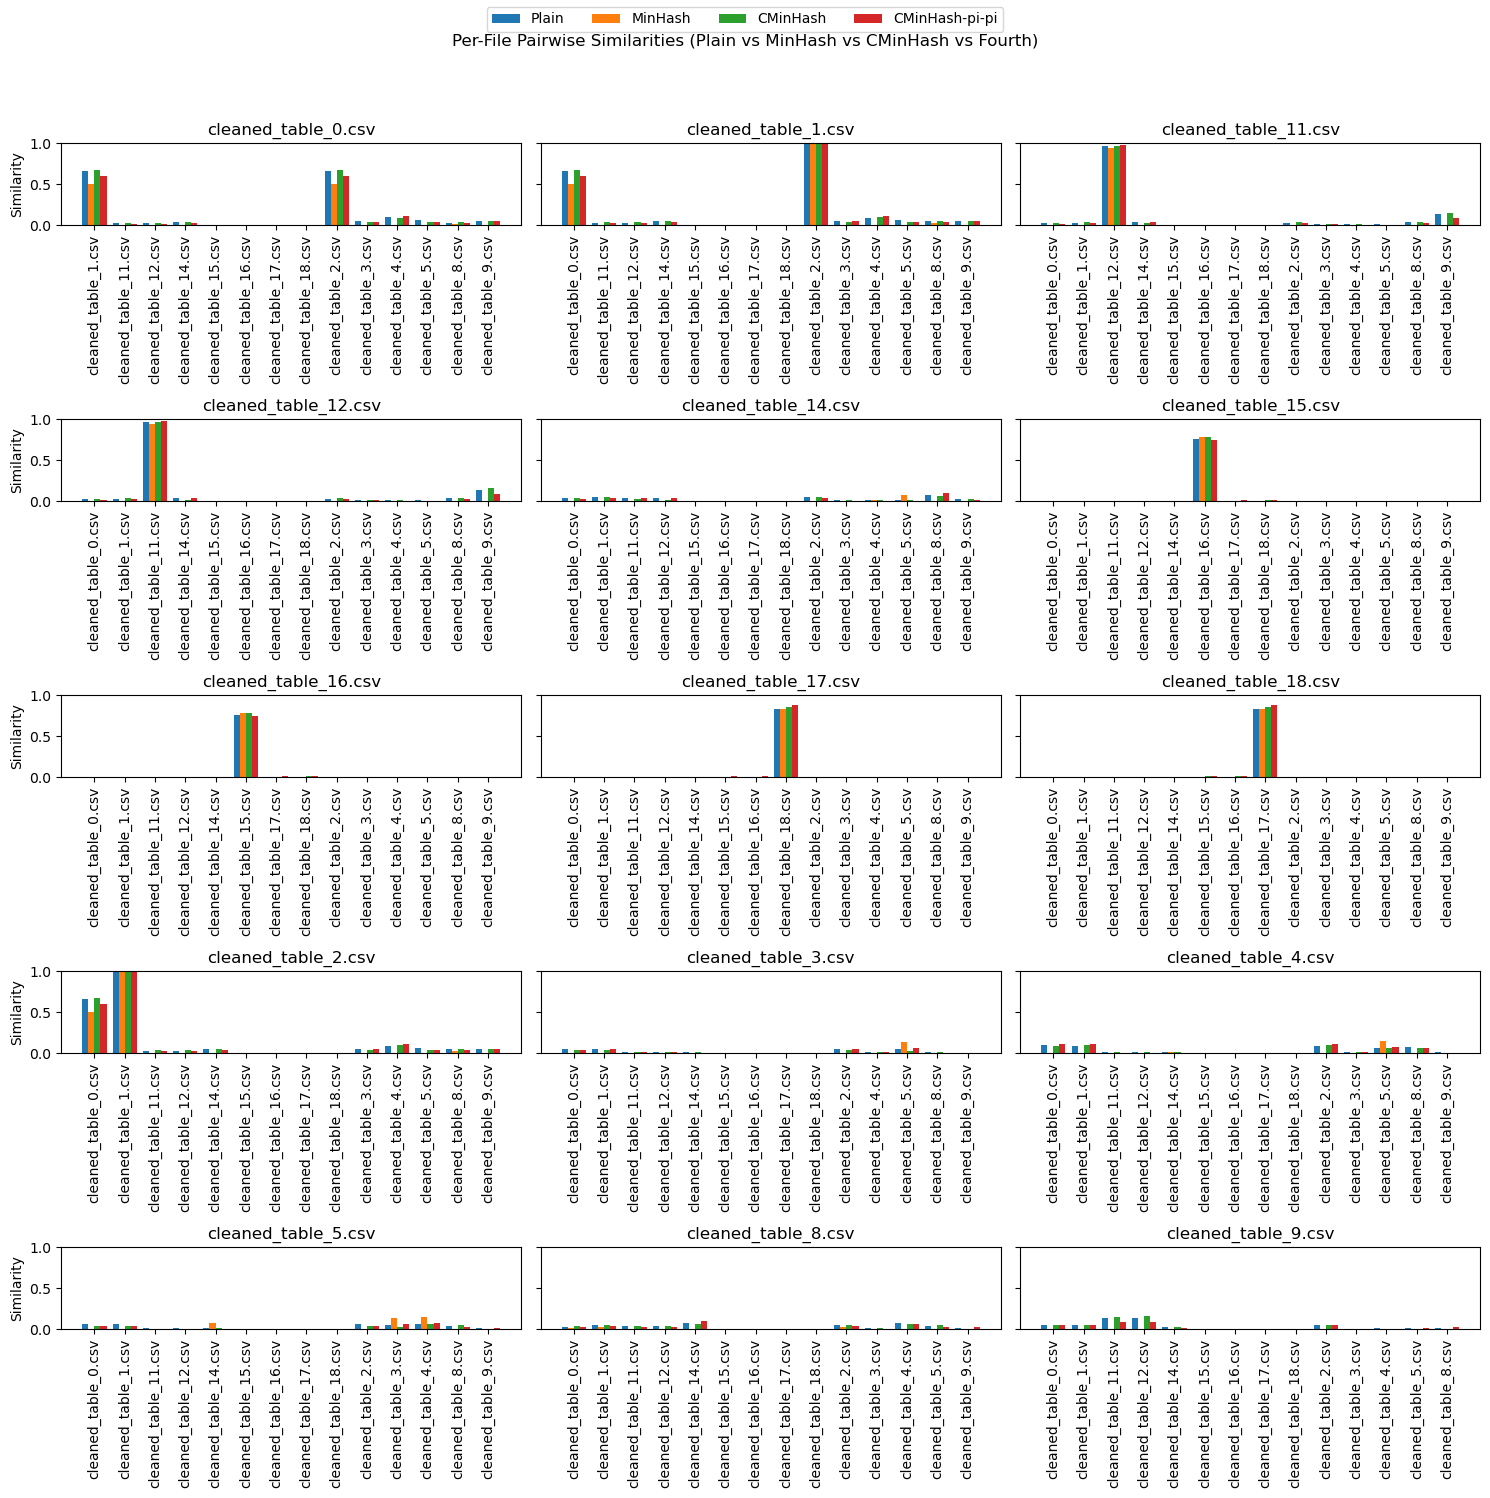

In [306]:
import numpy as np
import matplotlib.pyplot as plt

files = sorted(pdf.index)
n = len(files)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, max(6, rows * 3)), sharey=True)
axes = axes.flatten() if n > 1 else [axes]

bar_width = 0.2
offsets = (-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width)

for idx, anchor in enumerate(files):
    ax = axes[idx]
    others = [f for f in files if f != anchor]
    x = np.arange(len(others))

    y_plain = [plain_scores[anchor][o] for o in others]
    y_mh   = [hash_scores[anchor][o] for o in others]
    y_cmh  = [chash_scores[anchor][o] for o in others]
    y_cmhp = [chash_scores_pi[anchor][o] for o in others]

    ax.bar(x + offsets[0], y_plain, width=bar_width, label='Plain')
    ax.bar(x + offsets[1], y_mh,   width=bar_width, label='MinHash')
    ax.bar(x + offsets[2], y_cmh,  width=bar_width, label='CMinHash')
    ax.bar(x + offsets[3], y_cmhp, width=bar_width, label='CMinHash-pi-pi')

    ax.set_title(anchor)
    ax.set_xticks(x)
    ax.set_xticklabels(others, rotation=90)
    ax.set_ylim(0, 1)
    if idx % cols == 0:
        ax.set_ylabel('Similarity')


# One legend for all subplots (same as before)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)

fig.suptitle('Per-File Pairwise Similarities (Plain vs MinHash vs CMinHash vs Fourth)', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Task: For each table, find the top-5 most similar columns across all tables using Jaccard similarity of 8-shingles computed from each column’s flattened string. Return a tidy DataFrame with: source_file, source_col, match_file, match_col, jaccard, ranked by jaccard descending per source column.

Use already computed minhash_files and cminhash_files to build tidy DataFrames of pairwise Jaccard similarities (files × files) and a long-form table. Do not recompute signatures.

Code for LSH

In [307]:
from dataclasses import dataclass, field
from datasketch.hashfunc import sha1_hash32

@dataclass
class LSH:
    threshold: float = None
    b: int = 4
    r: int = 64
    num_perm: int = 256
    seed: int = 1
    hashfunc = sha1_hash32
    metadata = []

    def __post_init__(self):
        self.init_hashvalues()

    def init_hashvalues(self):
        self.hashvalues = np.empty(shape = (0, self.b * self.r), dtype=np.uint64)

    def add(self, minhash_list: List[ColStruct]):
        self.threshold = (1/self.b)**(1/self.r)
        print(f"approximate threshhold: {self.threshold}")
        minhash_digests = np.array([minhash.value.digest() for minhash in minhash_list], dtype=np.uint64)
        minhash_metadata = [(minhash.index, minhash.col_name) for minhash in minhash_list]
        self.metadata.extend(minhash_metadata)

        if (self.b * self.r != len(minhash_digests[0])):
            raise Exception("Invalid shape")

        self.hashvalues = np.append(self.hashvalues, minhash_digests, axis=0)

    def query(self, col: ColStruct) -> List[MinHash]:
        minhash_digests = np.array([col.value.digest()], dtype=np.uint64)
        if (self.b * self.r != len(minhash_digests[0])):
            raise Exception("Invalid shape")

        # VERY IMPORTANT WE SPLIT BY r
        hashvalues_split = np.split(self.hashvalues, self.b, axis=1)
        col_split = np.split(minhash_digests, self.b, axis=1)

        candidates = set()
        for i in range(self.b):
            w = np.where(np.all(hashvalues_split[i] == col_split[i], axis=1))
            if w is None or w is []:
                continue
            carr = w[0]
            candidates.add(tuple([self.metadata[j] for j in carr]))
        return candidates


In [308]:
lsh = LSH()

cmh_ci_exp = pd.DataFrame(cminhash_cols.values())
cmh_ci_exp = np.array(cmh_ci_exp).reshape(-1)
cmh_ci_exp = [c for c in cmh_ci_exp if c is not None]

lsh.add(cmh_ci_exp)

outs = {}

# For each table, print out all columns that are at least 97% similar
for i in range(len(cmh_ci_exp)):
    qr = lsh.query(cmh_ci_exp[i])
    if len(qr) > 1:
        print(cmh_ci_exp[i])
        outs[str(cmh_ci_exp[i])] = str(qr)
        print(qr)
        print()

json.dump(outs, open("./outputs/CMinHash_LSH_similar_rows_copy.json", "w"))


approximate threshhold: 0.9785720620877001
ColStruct(index=('cleaned_table_0.csv', 1), col_name='Quality Indicator', value=<__main__.CMinHashTest object at 0x000002E594A808A0>)
{((('cleaned_table_0.csv', 1), 'Quality Indicator'), (('cleaned_table_0.csv', 17), 'Quality Indicator.1'), (('cleaned_table_0.csv', 28), 'Quality Indicator.2'), (('cleaned_table_0.csv', 40), 'Quality Indicator.3'), (('cleaned_table_1.csv', 1), 'Quality Indicator'), (('cleaned_table_1.csv', 5), 'Quality Indicator.1'), (('cleaned_table_1.csv', 13), 'Quality Indicator.2'), (('cleaned_table_1.csv', 32), 'Quality Indicator.3'), (('cleaned_table_1.csv', 38), 'Quality Indicator.4'), (('cleaned_table_1.csv', 41), 'Quality Indicator.5'), (('cleaned_table_1.csv', 45), 'Quality Indicator.6'), (('cleaned_table_1.csv', 50), 'Quality Indicator.7'), (('cleaned_table_1.csv', 54), 'Quality Indicator.8'), (('cleaned_table_1.csv', 62), 'Quality Indicator.9'), (('cleaned_table_2.csv', 1), 'Quality Indicator'), (('cleaned_table_2.cs

You would have noticed that the data has some issues in them.
So perhaps those issues have been troublesome to deal with.

Please try to do some cleaning on the data.

After performing cleaning see if the results of the data discovery has changed?

Please try to explain this in your report, and try to match up the error with the observation.

In [309]:
## Cleaning data, scrubbing, washing, mopping

def cleaningData(data):
    """Function should be able to clean the data
    Possible Input: List of datasets
    Output: List of cleaned datasets
    """

    pass

## Discussions

1)  Different aspects of the data can effect the data discovery process. Write a short report on your findings. Such as which data quality issues had the largest effect on data discovery. Which data quality problem was repairable and how you choose to do the repair.

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words

You would have noticed that the data has some issues in them.
So perhaps those issues have been troublesome to deal with.

Please try to do some cleaning on the data.

After performing cleaning see if the results of the data discovery has changed?

Please try to explain this in your report, and try to match up the error with the observation.

In [310]:
## Cleaning data, scrubbing, washing, mopping

def cleaningData(data):
    """Function should be able to clean the data
    Possible Input: List of datasets
    Output: List of cleaned datasets
    """

    pass

# Part 2 - MinHash - Berken Tekin

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



Discovery algorithm:
1. Scan each database with read_csv.
2. Flatten each database, convert it to one string
3. Shingle with k=6
4. The MinHash and CMinHash values are calculated for each set of shingles
5. LSH returns pairs of columns with similarities above a threshold.


In [1]:
import numba
@numba.jit(nopython=True)
def kshingle_manual(s, k=6):
   sh = set()
   for i in range(len(s) - k + 1):
       sh.add(s[i:i + k])
   return list(sh)

We run the experiment twice for dirty and clean datasets.

In [2]:
csv_path = "./lake33c"

In [6]:
from collections import namedtuple
from collections import defaultdict
import os
import re
import pandas as pd

ColStruct = namedtuple("ColStruct", ["index", "col_name", "value"])

df_dict = {}
df_col_dict = defaultdict(list)

error_count_file = 0
for root, dirs, files in os.walk(csv_path):
    for csv_file in files:
        if os.path.splitext(csv_file)[1] == ".csv":
            file_path = os.path.join(root, csv_file)
            try:
                # Naive read_csv() as mentionmed ion the report
                df = pd.read_csv(file_path, sep=None, engine='python', on_bad_lines='skip', header=0)
                df = df.dropna().astype(object)
                # print(df)
            except Exception as e:
                continue
            # Serialize whole file (flattened)
            df_str = df.to_numpy().flatten()
            df_str = " ".join(str(x) for x in df_str).replace("\n", " ")
            df_str = re.sub(r"\s+", " ", df_str).strip()
            df_dict[csv_file] = df_str

            # Serialize each column for this file
            for col_idx, col in enumerate(df.columns):
                col_arr = df[col].to_numpy().flatten()
                col_str = " ".join(str(x) for x in col_arr).replace("\n", " ")
                col_str = re.sub(r"\s+", " ", col_str).strip()
                df_col_dict[csv_file].append(ColStruct(index=col_idx, col_name=str(col), value=col_str))

print(error_count_file)

0


22s to read files

In [7]:
from datasketch import MinHash, MinHashLSH
from typing import Callable, Generator, Iterable, List, Optional, Tuple
from datasketch.hashfunc import sha1_hash32
from tqdm import tqdm
import numpy as np


The datasketch.MinHash module is a good starting point to build the CMinHash algorithm.

For MinHash, at the beginning I did not really understand what the algorithm does.
Working on extending a module instead of starting from scratch helped me understand the algorithm better. I also learned about batch processing from datasketch.MinHash.

In [8]:
minhash_files = {}
cminhash_files = {}
cminhash_files_pi = {}
cminhash_cols = defaultdict(list)
cminhash_cols_pi = defaultdict(list)
minhash_cols = defaultdict(list)
lookup = {}
mh_file_ind = 0
hashvalue_byte_size = 4
# The size of a hash value in number of bytes


class CMinHashTest(MinHash):

    _large_prime = np.uint64((1 << 31) - 1) # A large prime
    _hash_range = 1 << 31

    def __init__(self, num_perm: int = 128, seed: int = 1234, hashfunc: Callable = sha1_hash32,
                 hashobj: Optional[object] = None, hashvalues: Optional[Iterable] = None,
                 permutations: Optional[Tuple[Iterable, Iterable]] = None, c_minhash_rotations: Optional[int] = None) -> None:
        super().__init__(num_perm, seed, hashfunc, hashobj, hashvalues, permutations)
        if c_minhash_rotations is not None: # Hard code
            self.c_minhash_rotations = c_minhash_rotations
        self.pi_permutations = self._init_pi_permutations()
        self.sigma_permutations = self._init_sigma_permutations()
        self.shift_right_precomputed = np.array([k for k in range(1, self.c_minhash_rotations + 1)], dtype=np.uint64).T


    def _init_sigma_permutations(self):
        gen = np.random.RandomState(self.seed + 1) # So we get different values for sigma permutation
        return np.array([
            gen.randint(1, self._large_prime, dtype=np.uint64),
            gen.randint(0, self._large_prime, dtype=np.uint64),
        ], dtype=np.uint64).T

    def _init_pi_permutations(self):
        # Create parameters for a random bijective permutation function
        # that maps a 32-bit hash value to another 32-bit hash value.
        # http://en.wikipedia.org/wiki/Universal_hashing
        gen = np.random.RandomState(self.seed)
        return np.array(
            [
                (
                    gen.randint(1, self._large_prime, dtype=np.uint64),
                    gen.randint(0, self._large_prime, dtype=np.uint64),
                )
            ],
            dtype=np.uint64,
        ).T


    def sf(self, hv):
        a, b = self.sigma_permutations
        return (hv * a + b) % self._large_prime

    def pf(self, hv) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * a + b) % self._large_prime

    # Another way of shifting the permutations.
    # The k offset is introduced at the end of the operation, instead of the beginning.
    # Here, "pia" holds (a * k + b % p) for all k.
    # https://github.com/beowolx/rensa/blob/95d80780f52f3105df4433132b279acd8c2762a0/src/cminhash.rs
    def pf2(self, hv, pia) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * a + pia) % self._large_prime

    def pf3(self, hv, off) -> np.ndarray:
        a, b = self.pi_permutations
        return (hv * (a - off) + b) % self._large_prime



    def update_batch_cminhash_pi_pi(self, b: Iterable) -> None:
        """Update this MinHash with new values.
        The values will be hashed using the hash function specified by
        the `hashfunc` argument in the constructor.

        """
        if self.c_minhash_rotations is None:
            raise ValueError("You need to specify c_minhash_rotations")

        hv = np.array([self.hashfunc(_b) for _b in b], dtype=np.uint64, ndmin=2).T
        phv = self.pf(hv)
        phv = self.pf3(phv, self.shift_right_precomputed)

        self.hashvalues = np.vstack([phv, self.hashvalues]).min(axis=0)


    def update_batch_cminhash_sigma_pi(self, b: Iterable) -> None:
        """Update this MinHash with new values.
        The values will be hashed using the hash function specified by
        the `hashfunc` argument in the constructor.

        """
        if self.c_minhash_rotations is None:
            raise ValueError("You need to specify c_minhash_rotations")

        hv = np.array([self.hashfunc(_b) for _b in b], dtype=np.uint64, ndmin=2).T
        phv = self.sf(hv)
        phv = self.pf3(phv, self.shift_right_precomputed)

        self.hashvalues = np.vstack([phv, self.hashvalues]).min(axis=0)


In [9]:

text_shinglesets = {}
col_shinglesets = defaultdict(set)

for fname, text in tqdm(df_dict.items()):
    cmh = CMinHashTest(num_perm=256, c_minhash_rotations=256)
    cmhp = CMinHashTest(num_perm=256, c_minhash_rotations=256)
    mh = MinHash(num_perm=256)

    ks = kshingle_manual(text)
    text_shinglesets[fname] = tuple(ks)
    max_buf=128
    for i in range(0, len(ks), max_buf):
        bufsize = min(len(ks)-i, max_buf)
        cmh.update_batch_cminhash_sigma_pi([e.encode("utf8") for e in ks[i:i+bufsize]])
        cmhp.update_batch_cminhash_pi_pi([e.encode("utf8") for e in ks[i:i+bufsize]])
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        cmh_col = CMinHashTest(num_perm=256, c_minhash_rotations=256)
        cmhp_col = CMinHashTest(num_perm=256, c_minhash_rotations=256)

        ks = kshingle_manual(col_value)
        cmh_col.update_batch_cminhash_sigma_pi([e.encode("utf8") for e in ks])
        cmhp_col.update_batch_cminhash_pi_pi([e.encode("utf8") for e in ks])
        cminhash_cols[fname].append(ColStruct((fname, col_idx), col_name ,cmh_col))
        cminhash_cols_pi[fname].append(ColStruct((fname, col_idx), col_name ,cmhp_col))
    cminhash_files[fname] = cmh
    cminhash_files_pi[fname] = cmhp


    for i in range(0, len(ks), max_buf):
        bufsize = min(len(ks)-i, max_buf)
        mh.update_batch([e.encode("utf8") for e in ks[i:i+bufsize]])
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        mh_col = MinHash(num_perm=256)
        ks = kshingle_manual(col_value)
        mh_col.update_batch([e.encode("utf8") for e in ks])
        minhash_cols[fname].append(ColStruct((fname, col_idx), col_name ,mh_col))

        col_shinglesets[fname].add(ColStruct((fname, col_idx), col_name, tuple(ks)))


    minhash_files[fname] = mh



100%|██████████| 16/16 [01:09<00:00,  4.33s/it]


In [10]:
import matplotlib.pyplot as plt

def jaccard_manual(set1, set2):
    set1 = set(set1)
    set2 = set(set2)

    intersection = set1.intersection(set2)
    union = set1.union(set2)

    if len(intersection) == 0:
        return 0.0
    return len(intersection) / len(union)


hash_scores = {}
chash_scores = {}
chash_scores_pi = {}
plain_scores = {}
for fname, content in minhash_files.items():
    hash_scores[fname] = {f: minhash_files[f].jaccard(content) for f in minhash_files.keys()}
for fname, content in cminhash_files.items():
    chash_scores[fname] = {f: cminhash_files[f].jaccard(content) for f in cminhash_files.keys()}

for fname, content in cminhash_files_pi.items():
    chash_scores_pi[fname] = {f: cminhash_files_pi[f].jaccard(content) for f in cminhash_files_pi.keys()}
for fname, content in text_shinglesets.items():
    plain_scores[fname] = {f: jaccard_manual(text_shinglesets[f], content) for f in text_shinglesets.keys()}

df = pd.DataFrame(hash_scores)
cdf = pd.DataFrame(chash_scores)
pdf = pd.DataFrame(plain_scores)
cpdf = pd.DataFrame(chash_scores_pi)

df.to_csv("outputs/hash_scores_clean.csv", index=False)
cdf.to_csv("outputs/chash_scores_clean.csv", index=False)
pdf.to_csv("outputs/plain_scores_clean.csv", index=False)
cpdf.to_csv("outputs/chash_scores_pi_clean.csv", index=False)



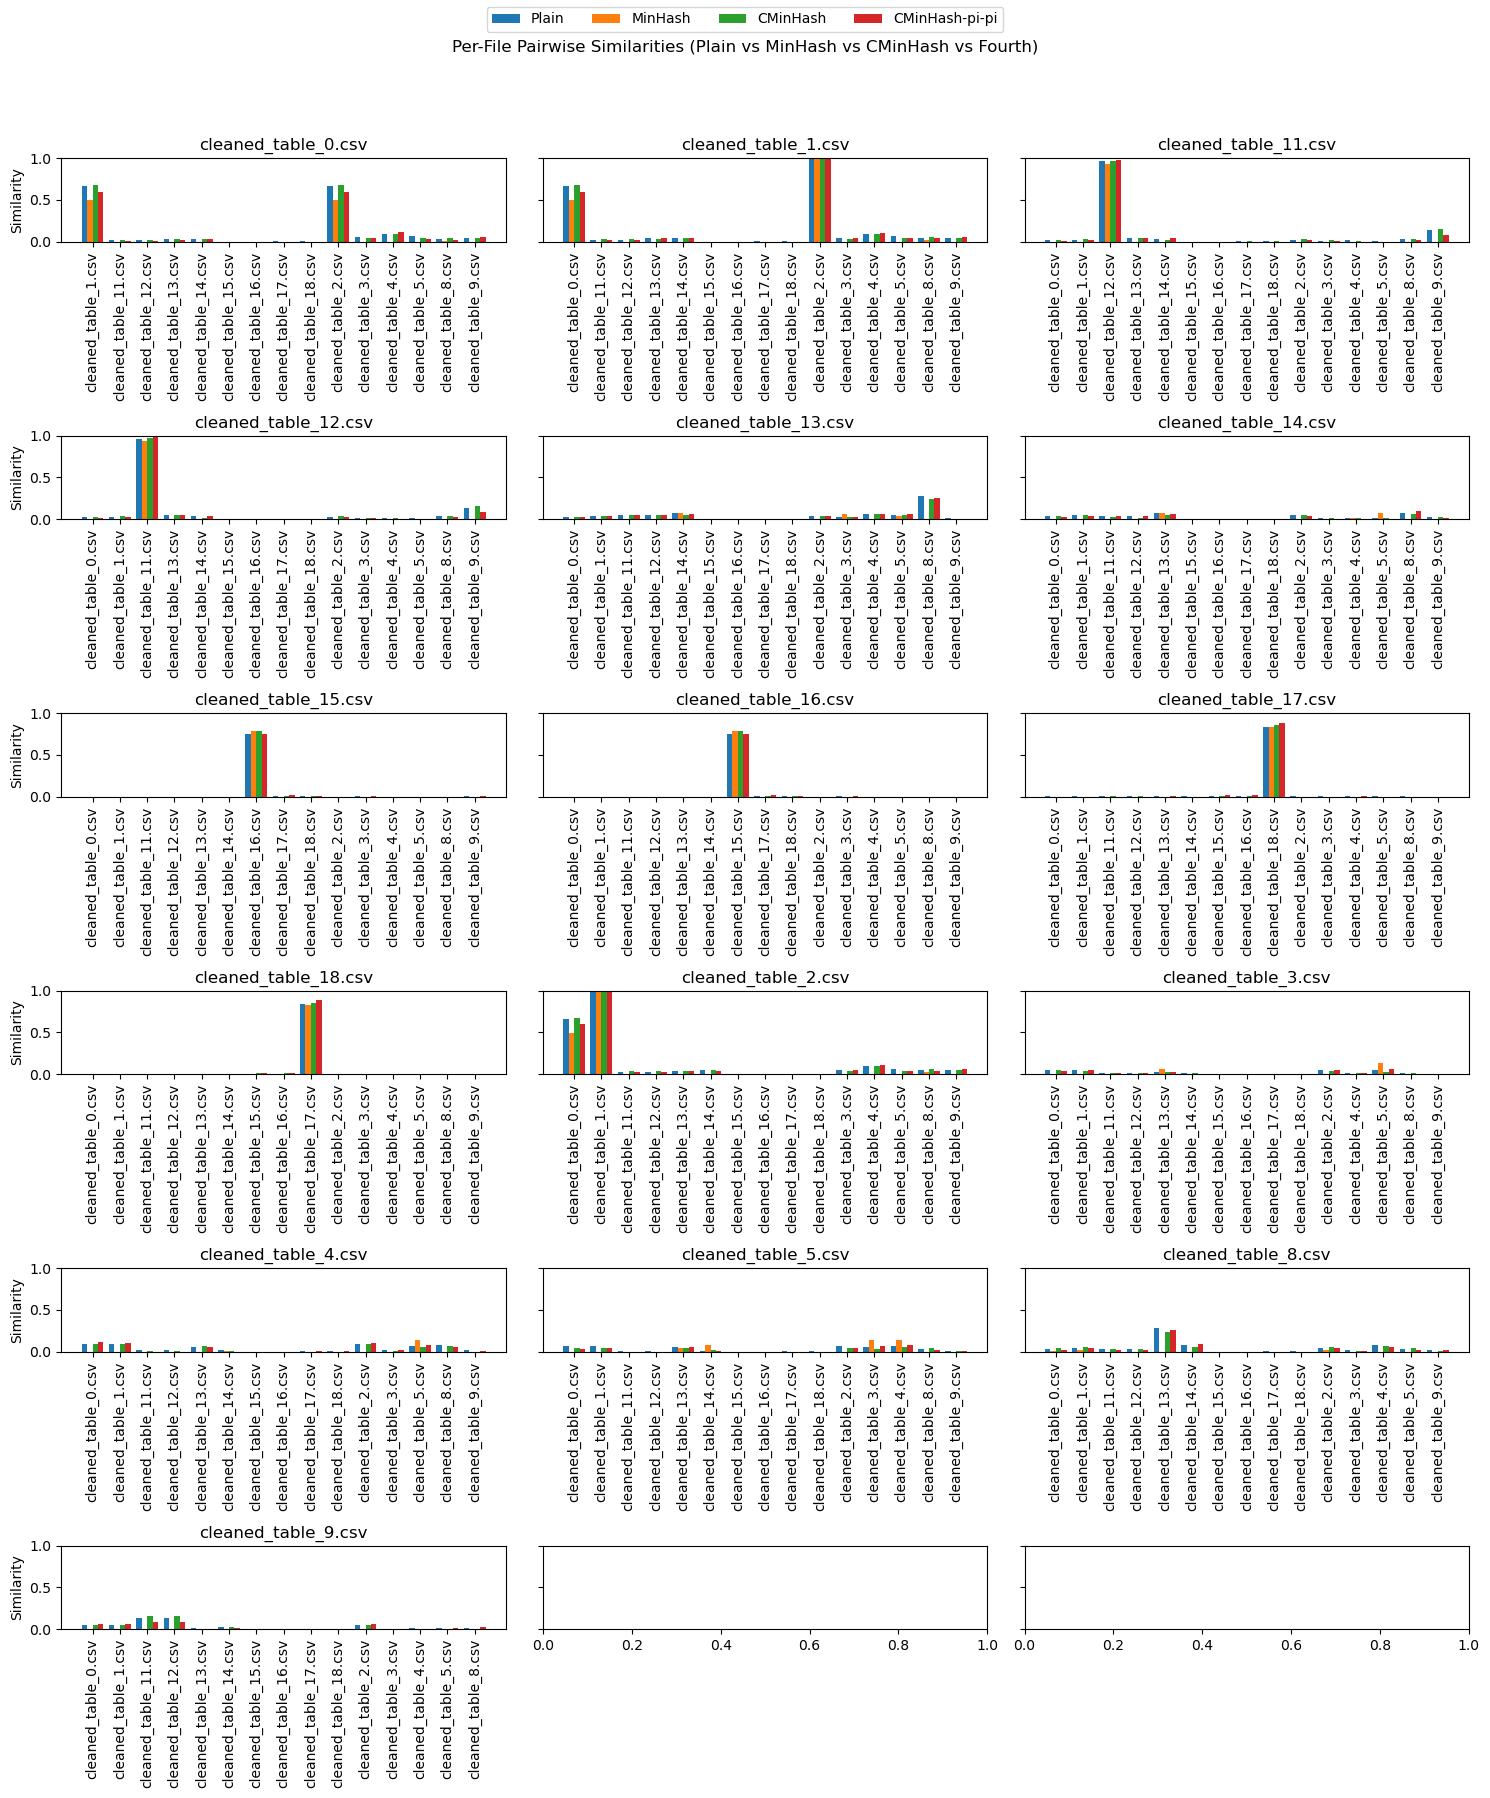

In [11]:
import numpy as np
import matplotlib.pyplot as plt

files = sorted(pdf.index)
n = len(files)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, max(6, rows * 3)), sharey=True)
axes = axes.flatten() if n > 1 else [axes]

bar_width = 0.2
offsets = (-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width)

for idx, anchor in enumerate(files):
    ax = axes[idx]
    others = [f for f in files if f != anchor]
    x = np.arange(len(others))

    y_plain = [plain_scores[anchor][o] for o in others]
    y_mh   = [hash_scores[anchor][o] for o in others]
    y_cmh  = [chash_scores[anchor][o] for o in others]
    y_cmhp = [chash_scores_pi[anchor][o] for o in others]

    ax.bar(x + offsets[0], y_plain, width=bar_width, label='Plain')
    ax.bar(x + offsets[1], y_mh,   width=bar_width, label='MinHash')
    ax.bar(x + offsets[2], y_cmh,  width=bar_width, label='CMinHash')
    ax.bar(x + offsets[3], y_cmhp, width=bar_width, label='CMinHash-pi-pi')

    ax.set_title(anchor)
    ax.set_xticks(x)
    ax.set_xticklabels(others, rotation=90)
    ax.set_ylim(0, 1)
    if idx % cols == 0:
        ax.set_ylabel('Similarity')


# One legend for all subplots (same as before)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)

fig.suptitle('Per-File Pairwise Similarities (Plain vs MinHash vs CMinHash vs Fourth)', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Task: For each table, find the top-5 most similar columns across all tables using Jaccard similarity of 8-shingles computed from each column’s flattened string. Return a tidy DataFrame with: source_file, source_col, match_file, match_col, jaccard, ranked by jaccard descending per source column.

Use already computed minhash_files and cminhash_files to build tidy DataFrames of pairwise Jaccard similarities (files × files) and a long-form table. Do not recompute signatures.

Code for LSH

In [13]:
from dataclasses import dataclass, field
from datasketch.hashfunc import sha1_hash32

@dataclass
class LSH:
    threshold: float = None
    b: int = 4
    r: int = 64
    num_perm: int = 256
    seed: int = 1
    hashfunc = sha1_hash32
    metadata = []

    def __post_init__(self):
        self.init_hashvalues()

    def init_hashvalues(self):
        self.hashvalues = np.empty(shape = (0, self.b * self.r), dtype=np.uint64)

    def add(self, minhash_list: List[ColStruct]):
        self.threshold = (1/self.b)**(1/self.r)
        print(f"approximate threshhold: {self.threshold}")
        minhash_digests = np.array([minhash.value.digest() for minhash in minhash_list], dtype=np.uint64)
        minhash_metadata = [(minhash.index, minhash.col_name) for minhash in minhash_list]
        self.metadata.extend(minhash_metadata)

        if (self.b * self.r != len(minhash_digests[0])):
            raise Exception("Invalid shape")

        self.hashvalues = np.append(self.hashvalues, minhash_digests, axis=0)

    def query(self, col: ColStruct) -> List[MinHash]:
        minhash_digests = np.array([col.value.digest()], dtype=np.uint64)
        if (self.b * self.r != len(minhash_digests[0])):
            raise Exception("Invalid shape")

        # VERY IMPORTANT WE SPLIT BY r
        hashvalues_split = np.split(self.hashvalues, self.b, axis=1)
        col_split = np.split(minhash_digests, self.b, axis=1)

        candidates = set()
        for i in range(self.b):
            w = np.where(np.all(hashvalues_split[i] == col_split[i], axis=1))
            if w is None or w is []:
                continue
            carr = w[0]
            candidates.add(tuple([self.metadata[j] for j in carr]))
        return candidates


In [15]:
import json
lsh = LSH()

cmh_ci_exp = pd.DataFrame(cminhash_cols.values())
cmh_ci_exp = np.array(cmh_ci_exp).reshape(-1)
cmh_ci_exp = [c for c in cmh_ci_exp if c is not None]

lsh.add(cmh_ci_exp)

outs = {}

# For each table, print out all columns that are at least 97% similar
for i in range(len(cmh_ci_exp)):
    qr = lsh.query(cmh_ci_exp[i])
    if len(qr) > 1:
        print(cmh_ci_exp[i])
        outs[str(cmh_ci_exp[i])] = str(qr)
        print(qr)
        print()

json.dump(outs, open("./outputs/CMinHash_LSH_similar_rows_copy.json", "w"))


approximate threshhold: 0.9785720620877001
ColStruct(index=('cleaned_table_0.csv', 1), col_name='Quality Indicator', value=<__main__.CMinHashTest object at 0x000002951C08E2C0>)
{((('cleaned_table_0.csv', 1), 'Quality Indicator'), (('cleaned_table_0.csv', 17), 'Quality Indicator.1'), (('cleaned_table_0.csv', 28), 'Quality Indicator.2'), (('cleaned_table_0.csv', 40), 'Quality Indicator.3'), (('cleaned_table_1.csv', 1), 'Quality Indicator'), (('cleaned_table_1.csv', 5), 'Quality Indicator.1'), (('cleaned_table_1.csv', 32), 'Quality Indicator.3'), (('cleaned_table_1.csv', 38), 'Quality Indicator.4'), (('cleaned_table_1.csv', 41), 'Quality Indicator.5'), (('cleaned_table_1.csv', 45), 'Quality Indicator.6'), (('cleaned_table_1.csv', 54), 'Quality Indicator.8'), (('cleaned_table_1.csv', 62), 'Quality Indicator.9'), (('cleaned_table_2.csv', 1), 'Quality Indicator'), (('cleaned_table_2.csv', 5), 'Quality Indicator.1'), (('cleaned_table_2.csv', 32), 'Quality Indicator.3'), (('cleaned_table_2.csv